In [9]:
import numpy as np
import random
from scipy.stats import beta
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
import torch
import tensorflow as tf
import math
import numbers
from IPython.display import HTML

# Student-t Processes as an Alternative to Gaussian Processes
### Laura Battaglia, Francesco Gandolfi and Maximilian Müller

# DISCLAIMER
For better readability one can hide the raw code of this notebook by importing the library HTML (just run the cell above) and running the cell below / clicking the toggle. There are several toggles throughout the notebook.

In [76]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Introduction


Gaussian Processes (GPs) are stochastic processes that allow to impose a wide range of different non-parametric priors over functions. Due to their flexibility, simple exact learning and inference procedures and good empirical performance,  they became renowned modeling tools in both Bayesian machine learning and signal processing over the last decades.

Given their success, it became natural to consider expanding the methodology to more general families of elliptical processes such as Student-t Processes (TPs). TPs can be seen as a generalised version of GPs: when TP's degrees of freedom $\nu \rightarrow \infty$, we can recover a GP with the corresponding mean and covariance functions. Indeed, <cite>Shah  et  al.  [2014]</cite>  argue that TP is the most general elliptical process with analytically representable density. Under the same assumptions over prior hyperparameters and kernel, and given the same training data, TPs allow for way more flexible posterior functional forms than GPs. In particular, longer tails provide robustness against outliers. Moreover, the predictive covariances explicitly depend on the training observations (while in GPs they only depend on training inputs), so that uncertainty in TPs usefully accounts for noise in the measurement, that in GPs is instead disregarded. 

# Theoretical framework overview

In our implementation we follow <cite>Tracey  and  Wolpert  [2018]</cite>, <cite>Shah  et  al.  [2014]</cite> and <cite>Solin  and  Särkkä [2015]</cite>.

### Prior distribution

We can define $y$ as being *multivariate Student-t* distributed with parameters $\nu \in \mathcal{R}_{+}\backslash [0,2], \phi \in \mathcal{R}^{n} $ and $K \in \Pi(n)$ when its density is of the form:
\begin{equation}
        p(\mathbf{y}) = \frac{\Gamma (\frac{\nu + n}{2})}
        {\Gamma(\frac{\nu}{2})
        ((\nu -2)\pi)^{\frac{n}{2}} 
        |K|^{\frac{1}{2}}} \times 
    \left(1 + \frac{(\mathbf{y}-\mathbf{\phi})^T K^{-1} (\mathbf{y}-\mathbf{\phi)}}{\nu-2}\right)^{-\frac{\nu+n}{2}}
\end{equation}
and we write $\mathbf{y} \sim \text{MVT}_n (\nu,\mathbf{\phi},K)$. 

$\nu$ measures the degrees of freedom, $\mathbf{\phi}$ is the unconditional mean of the process (assumed to be equal to the zero vector for our purposes) and $K$ is the covariance stemming from our kernel choice. This distribution will represent the prior distribution to our TP.

The Student-t distribution can be defined as a scale mixture of Gaussians <cite>(Lange et al. [2010])</cite>. Indeed, we can retrieve  $\mathbf{y}\sim \text{MVT}_n (\nu,\mathbf{\phi},K)$ from the following mixture:

\begin{align*}
    r &\sim \chi^{2}(\nu)\\
    \mathbf{x} &\sim \text{N}_n(\mathbf{\phi},K)\\
    \mathbf{y} & = \frac{\mathbf{x}}{\sqrt{r/\nu}}
\end{align*}

We will exploit this representation of a Student-t distributed variable in order draw and display random samples from a TP prior. 
 
As to the choice of kernel, in the following implementation we make use of a standard Squared-Exponential (SE) kernel:
\begin{equation}
    k(\mathbf{x}_p, \mathbf{x}_q) = 
    \sigma^2_f 
    exp(-\frac{1}{2l^2}
    \|\mathbf{x}_p - \mathbf{x}_q\|^2))
\end{equation}

where $l$ is the length-scale parameter and $\sigma^2_f$ the signal variance parameter.
However, the code is flexible to a different kernel choice for a given set of hyperparameters. 
 
### Posterior distribution 
 
The Student-t distribution thus inherits several appealing features from the Gaussian, including an analytic conditional i.e. posterior distribution.

In particular, in the supplementary material of <cite>Shah  et  al.  [2014]</cite> it is shown that the conditional distribution of $\mathbf{y_{2}}$ given observed data $\mathbf{y_{1}}$ has the following analytical expression:

\begin{equation}\label{condDistStudent}
    \mathbf{y_2}|\mathbf{y_1} \sim \text{MVT}_{n_2}\left(\nu+n_1, \tilde{\mathbf{\phi}_2}, \frac{\nu+\beta_1 -2}{\nu+n_1-2} \times \tilde{K_{22}}         \right)    
\end{equation}

where $\tilde{\mathbf{\phi}_2} = K_{21}K_{11}^{-1}(\mathbf{y_1}-\mathbf{\phi}_1)+\phi_2$, $\beta_1 = (\mathbf{y_1} - \phi_1^T)K_{11}(\mathbf{y_1}-\phi_1)$, $\tilde{K_{22}}=K_{22} - K_{21}K_{11}^{-1}K_{12}$ and $n_1$ and $n_2$ are the sizes of $\mathbf{y_1}$ and $\mathbf{y_2}$ respectively. 

We can thus retrieve the posterior mean $E( \mathbf{y_2}|\mathbf{y_1}) = \tilde{\mathbf{\phi}_2}$ and the posterior variance $Cov( \mathbf{y_2}|\mathbf{y_1}) =  \frac{\nu + \beta_1 - 2}{\nu + n_1 - 2}\tilde{K_{22}}$.

It is to note that the posterior mean $\tilde{\phi_2}$ is equivalent to the one obtained for Gaussian processes. The variance, however, differs, and in particular it explictly captures uncertainty in output measurement ($\mathbf{y_1}$) that in GPs is disregarded.


### Hyperparameter optimization
In a realistic scenario neither the kernel parameters nor an appropriate value of $\nu$ is known. A common approach is therefore to optimize over a set of parameters by minimizing the negative log-likelihood, which can be expressed as 
\begin{equation}\label{loglik}
\begin{split}
    \mathcal{L}(\mathbf{\theta})&=-\log(\mathbf{y}|\mathbf{\theta},\nu)\\
    &=\frac{n}{2}\log((\nu - 2)\pi) + \frac{1}{2}\log(|K|)-\log(\frac{\nu - 2}{2}) + \log(\Gamma(\frac{\nu}{2}))+\frac{\nu + n}{2}\log(1+\frac{\beta}{\nu -2})
    \end{split}
\end{equation}
Though not explicitly visible, the log-likelihood depends on the kernel parameters through the log-determinant of $K$.

A major contribution of our implementation is that we will optimize the hyperparameters of the model via a Gradient Descent algorithm implemented in Pytorch. This will allow us to tune the hyperparameters to best fit the training data. 

# Implementation outline

In our implementation we take the following steps:
   + Present python classes for GP and TP processes 
   + Draw and display samples from GP and TP priors for comparison
   + Show performance of GP and TP processes when predicting over a test sample of synthetic data
   + Test GP and TP prediction performance with real data

# TP and GP classes

TP and GP classes include methods for drawing prior samples, fitting on training data and predicting over test data. In particular, we point at the following:

   + Classes can handle uni-dimensional as well as multi-dimensional input data
   + They allow for hyperparameter optimization during training via a gradient descent algorithm implemented with Pytorch 
   + For a given set of hyperparameters, they are flexible to the choice of a kernel other than the default SE kernel. The optimization part is at this stage tuned to a SE kernel, but that could easily be extended.

In [66]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
We hide the raw code of this notebook for better readability.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [11]:
def kernel_f(x1,x2,l,sigma_f):
    return (sigma_f**2) * \
        np.exp(-((x1-x2)**2)/(2*(l**2)))

#### Gaussian Process

In [22]:
class GProcess():
    def __init__(self,sigma_n=1,kernel=None,**kwargs):
        '''
        Initialize a Gaussian process, the hyparameters are:
        
        sigma_n: noise for the diagonal entries of the covariance Matrix
        
        kernel: kernel function, receives as input two points and the kernel hyperparameters and returns
        '''
        
        # initialize hyperparameters and kernel, if you don't put a kernel defaults to SE kernel
        self.sigma_n = sigma_n
        if kernel is None:
            self.kernel = self.se_kernel
            self.kernel_pars = (1,1)
            self.kernel_pars_names=('l,sigma_f')
        else:
            self.kernel = kernel
            self.kernel_pars = tuple(kwargs.values())
            self.kernel_pars_names=tuple(kwargs.keys())

            
    @staticmethod
    def se_kernel(x1,x2,l,sigma_f):
        '''
        Squared exponential kernel, the parameters are:

        x1,x2: points to calculate the covariance over
        
        l: float, lengthscale parameter
        
        sigma_f: float, output variance
        '''
        return (sigma_f**2) * \
            np.exp(-((x1-x2)**2)/(2*(l**2)))
    
    def change_hyperp(self,nu,rho,sigma_n,**kwargs):
        '''
        Function to set new hyperparameter for the process
        '''
        self.sigma_n = sigma_n
        self.kernel_pars = tuple(kwargs.values())

    def fit_sigma(self, X):
        '''
        Compute Kernel matrix
        '''
        n=len(X)
        sigma=np.zeros(shape=(n,n))
        for i in range(n):
            for j in range(n):
                sigma[i,j]=self.kernel(X[i],X[j],*self.kernel_pars)
        return sigma
    
    def _draw_from_prior(self,num_samples,X):
        '''
        draw samples for y from the prior distribution
        '''
        samples = []
        Sigma = self.fit_sigma(X)
        sigma_point=np.sqrt(Sigma[0,0])*1.96
        for i_sample in range(num_samples):
            mu= np.zeros(len(X))
            samples+=[np.random.multivariate_normal(mu,Sigma,size=1)[0]]  
        return samples, sigma_point
    
    def plot_prior_samples(self, xmin, xmax, num_samples):
        '''
        Plot samples from the prior distribution in the interval xmin-xmax
        '''
        X = np.linspace(xmin,xmax,100)
        samples,sigma_point = self._draw_from_prior(num_samples,X)
        fig=plt.figure(figsize=(10,6))
        plt.fill_between(x=X,y1=sigma_point,y2=-sigma_point,color='lightgrey',label='95% confidence')
        for sample in samples:
            plt.plot(X,sample)
        plt.title('GP: Random Samples of Prior, $l$={}, $\sigma_f$ = {}, $\sigma_n$ = {}'.format(self.kernel_pars[self.kernel_pars_names=='l'],self.kernel_pars[self.kernel_pars_names=='sigma_f'],self.sigma_n))
        plt.xlim(xmin,xmax)
        plt.show()
        
    
    def fit(self, X, y, optimize_SE = False, threshold = .000001,lr=0.03):
        '''
        Fit the process for given training data. This method calculates the covariance matrix for the train data
        and inverts it. The parameters are:
        
        X: array-like
        
        y: array like, with same number of rows as X
        
        optimize_SE: boolean, when True the method optimizes kernel hyperparameters 
                     via gradient descent.
                     IMPORTANT: Works only for Squared Exponential Kernel
        
        threshold: float, stop hyperparameters optimization when the change in likelihood during gradient descent
                   is smaller than threshold
        
        lr: learning rate for optimizer
        '''
        
        self.X = X
        self.y = y
        
        if optimize_SE:
            # only for SE kernel
            self.sigma_n,l,sigma_f=self._optimize_SE(self.X,self.y,threshold,lr=lr)
            self.kernel_pars = (l,sigma_f)
            print('l, sigma_f')
            print(self.kernel_pars)
        
        self.Sigma = self.fit_sigma(X)
        
        self.L=np.linalg.cholesky(self.Sigma+np.diag([self.sigma_n**2 + .00001 for _ in range(len(X))]))
        L_inv = np.linalg.inv(self.L)
        self.alpha=L_inv.T@L_inv

    def _predict_point(self, x_test):
        '''
        function to predict expected value and variance of one observation, users should call the function predict
        not this one
        ''' 
        n=len(self.X)
        
        # compute K21 and K12
        k_test_train = [self.kernel(x_test, x,*self.kernel_pars) for x in self.X]
        k_test_train = np.array([k + (self.sigma_n)**2*(k==0) for k in k_test_train])
        k_train_test = [self.kernel(x, x_test,*self.kernel_pars) for x in self.X]
        k_train_test = np.array([k + (self.sigma_n**2)*(k==0) for k in k_train_test])
        
        # compute expected value of x_test
        mean_test = k_test_train@self.alpha@self.y
        
        # compute variance of the prediction of x_test
        var_test =self.kernel(x_test,x_test,*self.kernel_pars) + self.sigma_n**2 - k_test_train.T@self.alpha@k_train_test

        return mean_test, var_test    
    
    def predict(self, X_test):
        '''
        Generate estimates for input data points
        '''         
        if isinstance(X_test, numbers.Number):
            return self._predict_point(X_test)
        if not isinstance(X_test[0], numbers.Number):
            if(len(X_test[0])==1 and len(X_test)==len(self.X[0])):
                return self._predict_point(X_test)
        
        y_preds=np.zeros(len(X_test))
        v_preds=np.zeros(len(X_test))
        for idx,x_test in enumerate(X_test):
            y_preds[idx],v_preds[idx]=self._predict_point(x_test)
        return y_preds, v_preds

    def plot_range(self, xmin, xmax):
        '''
        plot prediction and confidence bound in the interval [xmin, xmax]
        '''
        X_test=np.linspace(xmin,xmax,100)
        y_preds, v_preds = self.predict(X_test)
        self.v_preds = v_preds

        plt.figure(figsize=(16,4))
        plt.title('GP Prediction')
        plt.fill_between(x=X_test,y1=y_preds+1.96*np.sqrt(v_preds),y2=y_preds-1.96*np.sqrt(v_preds),color='lightgrey',label='95% CI')
        plt.plot(X_test,np.array(y_preds),label='Prediction')
        plt.scatter(self.X,self.y,label='Train Data', color = 'black', s = 14)
        plt.xlim(xmin,xmax)
        plt.legend(loc = 'lower right')
        
    def _optimize_SE(self,X,y,threshold,lr):
        '''
        Function to optimize the hyperparameters of an SE kernel
        '''
        sigma_f = torch.distributions.uniform.Uniform(0.2,0.8).sample().requires_grad_(True)
        l = torch.distributions.uniform.Uniform(0.2,0.8).sample().requires_grad_(True)
        
        n = len(X_train)
        prev_loss = np.inf
        k_1 = np.array([np.array([-((x1-x2)**2) for x2 in X]) 
                        for x1 in X])
        iteration = 0
        optimizer = torch.optim.Adagrad([sigma_f,l],lr=lr)
        sigma_n = torch.tensor(self.sigma_n)
        stop = False
        while not stop:
            iteration+=1
            optimizer.zero_grad()

            K = (sigma_f**2)*torch.exp(torch.from_numpy(k_1)/(2 * l**2))+ \
                torch.eye(len(X_train))*(sigma_n**2)

            y_tens = torch.from_numpy(y).unsqueeze(1)
            
            logl = -0.5*torch.mm(torch.mm(torch.transpose(y_tens,0,1),torch.inverse(K)),y_tens)-0.5*torch.logdet(K)-\
                    0.5*n*torch.log(torch.tensor(2*np.pi))
            
            # restart if not converging
            if np.isnan(float(logl)):
                sigma_n = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
                sigma_f = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
                l = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)               
                iteration = 0
                
            loss = -logl
            stop = abs(loss-prev_loss)<threshold or iteration>10000
            if stop:
                print(iteration)
            prev_loss = float(loss)
            loss.backward()
            optimizer.step()
        return float(sigma_n),float(l),float(sigma_f)

#### Student-t Process

In [69]:
class TProcess():
    def __init__(self,nu=100,sigma_n=.5,kernel=None,**kwargs):
        '''
        Initialize an T-Student process, the hyparameters are:
        
        nu: float, # of degrees of freedom, default=100
        
        sigma_n: float, noise for the diagonal entries of the covariance Matrix, default=1
        
        kernel: function, kernel function that receives as input two points x1 and x2 and the kernel hyperparameters and returns the estimation
                of the covariance between x1 and x2, default = SE kernel with l=sigma_f=1
                
        **kwargs: all the hyperparameters of the kernel function, in the same order as used as input of the kernel function
        '''
        
        # initialize hyperparameters and kernel, if you don't put a kernel defaults to SE kernel
        self.nu = nu
        self.sigma_n = sigma_n
        if kernel is None:
            self.kernel = self.se_kernel
            self.kernel_pars = (1,1)
            self.kernel_pars_names=('l,sigma_f')

        else:
            self.kernel = kernel
            self.kernel_pars = tuple(kwargs.values())
            self.kernel_pars_names=tuple(kwargs.keys())
            
    
    @staticmethod
    def se_kernel(x1,x2,l,sigma_f):
        '''
        Squared exponential kernel, the parameters are:

        x1,x2: points to calculate the covariance over
        
        l: float, lengthscale parameter
        
        sigma_f: float, output variance
        '''
        return (sigma_f**2) * \
            np.exp(-(np.linalg.norm(x1-x2)**2)/(2*(l**2)))
    
    def change_hyperp(self,nu,rho,sigma_n,**kwargs):
        '''
        Function to set new hyperparameter for the process
        '''
        self.nu = nu
        self.rho = rho
        self.sigma_n = sigma_n
        self.kernel_pars = tuple(kwargs.values())

    def fit_sigma(self, X):
        '''
        Compute Kernel matrix
        '''
        n=len(X)
        kernel_function = self.kernel
        sigma=np.zeros(shape=(n,n))
        for i in range(n):
            for j in range(n):
                sigma[i,j]=kernel_function(X[i],X[j],*self.kernel_pars)
        return sigma
    
    def _draw_from_prior(self,num_samples,X):
        '''
        draw samples for y from the prior distribution
        '''
        samples = []
        Sigma = self.fit_sigma(X)
        sigma_point=np.sqrt(Sigma[0,0])*stats.t(df=self.nu).ppf((0.025))
        for i_sample in range(num_samples): 
            mu= np.zeros(len(X))
            d = len(mu)
            if self.nu == np.inf:
                x = 1.
            else:
                x = np.random.chisquare(self.nu, 1)/self.nu
            z = np.random.multivariate_normal(np.zeros(d),Sigma,(1,))
            samples+=[(mu + z/np.sqrt(x)[:,None])[0]]
        return samples, sigma_point
    
    def plot_prior_samples(self, xmin, xmax, num_samples):
        '''
        Plot samples from the prior distribution in the interval xmin-xmax
        '''
        X = np.linspace(xmin,xmax,100)
        samples,sigma_point = self._draw_from_prior(num_samples,X)
        fig=plt.figure(figsize=(10,6))
        plt.fill_between(x=X,y1=sigma_point,y2=-sigma_point,color='lightgrey',label='95% confidence')
        for sample in samples:
            plt.plot(X,sample)
        #plt.title(f'TP Random Samples of Prior, $ l={self.kernel_pars[0]}, \ \sigma_f={self.kernel_pars[1]}, \ \sigma_n={self.sigma_n} $', fontsize=10)
        plt.title('TP: Random Samples of Prior, $l$={}, $\sigma_f$ = {}, $\sigma_n$ = {}, df = {}'.format(self.kernel_pars[self.kernel_pars_names=='l'],self.kernel_pars[self.kernel_pars_names=='sigma_f'],self.sigma_n,self.nu))
        plt.xlim(xmin,xmax)
        plt.show()
        
    
    def fit(self, X, y, optimize_SE = False, threshold = .000001,lr=0.03):
        '''
        Fit the process for given training data. This method calculates the covariance matrix for the train data
        and inverts it. The parameters are:
        
        X: array-like
        
        y: array like, with same number of rows as X
        
        optimize_SE: boolean, when True the method optimizes degrees of freedom and kernel hyperparameters 
                     via gradient descent.
                     IMPORTANT: Works only for Squared Exponential Kernel
        
        threshold: float, stop hyperparameters optimization when the change in likelihood during gradient descent
                   is smaller than threshold
        '''
        if optimize_SE:
            # only for SE kernel, find optimal hyperparameters
            self.nu,self.sigma_n,l,sigma_f=self._optimize_SE(X,y,threshold,lr=lr)
            self.kernel_pars = (l,sigma_f)
            
        #store train data
        self.X = X
        self.y = y
        
        # compute covariance matrix for training data
        self.Sigma = self.fit_sigma(X)
        
        # Cholesky decomposition to efficiently invert the covariance matrix
        L=np.linalg.cholesky(self.Sigma+np.diag([self.sigma_n**2+.00001 for _ in range(len(X))]))
        L_inv = np.linalg.inv(L)
        self.alpha=L_inv.T@L_inv

    def _predict_point(self, x_test):
        '''
        function to predict expected value and variance of one observation, users should call the function predict
        not this one
        ''' 
        n=len(self.X)
        kernel_function=self.kernel
        # compute K21 and K12 and add sigma_n noise in the diagonal
        k_test_train = [kernel_function(x_test, x,*self.kernel_pars) for x in self.X]
        k_test_train = np.array([k + (self.sigma_n)**2*(k==0) for k in k_test_train])
        k_train_test = [kernel_function(x, x_test,*self.kernel_pars) for x in self.X]
        k_train_test = np.array([k + (self.sigma_n**2)*(k==0) for k in k_train_test])
        
        # compute expected value of x_test
        mean_test = k_test_train@self.alpha@self.y
        
        # compute variance of the predicted mean of x_test
        k_22_tilde = kernel_function(x_test,x_test,*self.kernel_pars) - k_test_train@self.alpha@k_train_test
        beta = self.y.T@self.alpha@self.y
        var_test = k_22_tilde*(self.nu+beta-2)/(self.nu+n-2)

        return mean_test, var_test

    
    def predict(self, X_test):
        '''
        Generate estimates for input data points
        '''      
        # main predict method, shoudl be able to understand whether we are trying to predict one point
        # or a series of points
        if isinstance(X_test, numbers.Number):
            return self._predict_point(X_test)
        if not isinstance(self.X[0], numbers.Number):
            if isinstance(X_test[0], numbers.Number):
                if(len(X_test)==len(self.X[0])):
                    return self._predict_point(X_test)

        y_preds=np.zeros(len(X_test))
        v_preds=np.zeros(len(X_test))
        for idx,x_test in enumerate(X_test):
            y_preds[idx],v_preds[idx]=self._predict_point(x_test)
        return y_preds, v_preds

    def plot_range(self, xmin, xmax):
        '''
        plot prediction and confidence bound in the interval [xmin, xmax] (only for 1-D X)
        '''
        X_test=np.linspace(xmin,xmax,100)
        y_preds, v_preds = self.predict(X_test)
        pref = stats.t(df=self.nu+len(self.X)).ppf((0.025))
        
        plt.figure(figsize=(16,4))
        plt.title('TP Prediction')
        plt.fill_between(x=X_test,y1=y_preds+pref*np.sqrt(v_preds),y2=y_preds-pref*np.sqrt(v_preds),color='lightgrey',label='95% CI')
        plt.plot(X_test,np.array(y_preds),label='Prediction')
        plt.scatter(self.X,self.y,label='Train Data', color = 'black', s = 14)
        plt.xlim(xmin,xmax)
        plt.legend(loc = 'lower right')
        
    def _optimize_SE(self,X,y,threshold,lr):
        '''
        Function to optimize the number of degrees of freedom and the hyperparameters of an SE kernel
        '''
        #randomly initialize the hyperparameters
        nu = torch.distributions.uniform.Uniform(2.00001, 19).sample().requires_grad_(True)
        #sigma_n = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
        sigma_f = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
        l = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
        
        n = len(X_train)
        prev_loss = np.inf
        #compute matrix of pairwise negative squared distances between points in X
        k_1 = np.array([np.array([-(np.linalg.norm(x1-x2)**2) for x2 in X]) 
                        for x1 in X])
        
        iteration = 0
        #optimizer = torch.optim.Adagrad([nu,sigma_n,sigma_f,l])
        optimizer = torch.optim.Adagrad([nu,sigma_f,l],lr=lr)
        if self.sigma_n >0:
            sigma_n = torch.tensor(self.sigma_n)
        else:
            sigma_n = 0.000001
        
        stop = False
        
        while not stop:
            iteration+=1
            optimizer.zero_grad()
            
            # Covariance matrix
            K = (sigma_f*sigma_f)*torch.exp(torch.from_numpy(k_1)/(2*l*l))+ \
                torch.eye(len(X_train))*(sigma_n*sigma_n)

            y_tens = torch.from_numpy(y).unsqueeze(1)
            beta = torch.mm(y_tens.T,torch.inverse(K))
            beta = torch.mm(beta,y_tens)
            
            # compute log-likelihood
            logl = -(n/2)*torch.log((nu-2)*torch.tensor(np.pi)) - 0.5*torch.logdet(K)+ \
                torch.lgamma(0.5*(nu+n)) - torch.lgamma(0.5*nu) - \
                0.5*(nu+n)*torch.log(1+(beta/(nu-2)))
            
            # if the loglikelihood is nan (hyperparameters are outside their boundary) reinitilize all hyperparameters
            if nu < 2 or sigma_n < 0 or l < 0:
                nu = torch.distributions.uniform.Uniform(2.00001, 19).sample().requires_grad_(True)
                sigma_n = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
                sigma_f = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)
                l = torch.distributions.uniform.Uniform(1,4).sample().requires_grad_(True)               
                iteration = 0
                stop=False
            else:   
                loss = -logl

                #compute change in likelihood, if very small or we have compute 10000 gd steps stop
                stop = abs(loss-prev_loss)<threshold or iteration>10000
                prev_loss = float(loss.detach())

                # compute gradient and take a step thowards the minimum
                loss.backward()
                optimizer.step()
        return float(nu),float(sigma_n),float(l),float(sigma_f)

# Prior Plots and Experiments

In this section we want to get an intuition on how the Student-t priors behave compared to the conventional Normal Priors of GPs. We therefore take advantage of the above introduced classes and plot random draws of the corresponding prior distributions. Since we are already familiar with the effect of the Kernel parameters, we keep these for both processes constant and vary only the degrees of freedom $\nu$ (sometimes referred to as df) for the TPs. 

In particular, below we can see four plots showing 100 random draws from processes with SE kernel and a given set of parameters $(\sigma_n = 0.1, \sigma_f = 1.5, l = 1,2)$ for a GP, a TP(df=3), a TP(df=5) and a TP(df=500) respectively.

We can make the following observations:
* As expected, the Student-t Priors allow for more extreme values. In particular, the most extrem observation for $\nu=3$ goes up to a value of more than 10, which would never happen for the Gaussian process for $\sigma_f=1.5$
* The confidence interval of the Student-t prior is always larger than that of the Gaussian process, and this is more so as $\nu$ decreases. It is to note that both the confidence interval and the variance of the Student-t function depends on $\nu$, though. In particular, the variance of the TP Prior scales with $\frac{\nu}{\nu - 2}$ compared to a Gaussian process. Moreover, the TP confidence interval is as well influenced by the Student-t pdf quantiles for a 95% Confidence Interval (CI), which take more extreme values for a lower $\nu$. 
* Conversely, as $\nu\to\infty$ one re-discovers the conventional Gaussian processes which aligns well with the theory described in the first section
* Degrees of freedom $\nu$ thus allow to scale on how extreme one allows the observations to be. Small values of $\nu$ can capture high variation at the cost of an increased confidence interval and vice versa

In [14]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
We hide the raw code of this notebook for better readability.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

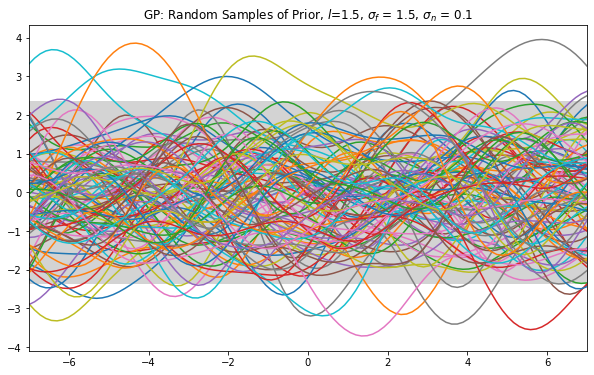

In [24]:
model_GP = GProcess(sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.2)
model_GP.plot_prior_samples(-7,7,100)

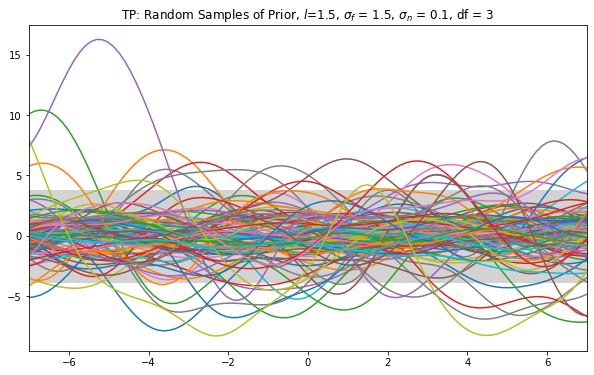

In [70]:
model_TP = TProcess(nu=3,sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.2)
model_TP.plot_prior_samples(-7,7,100)

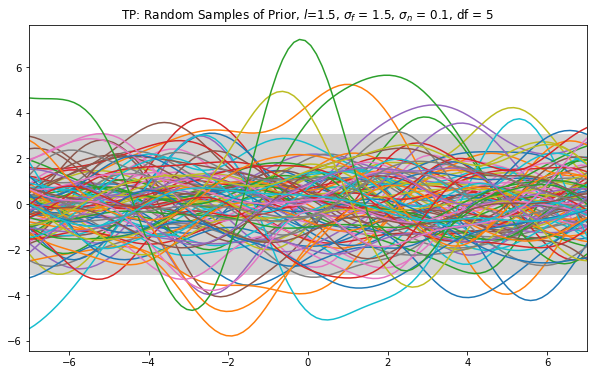

In [71]:
model_TP2 = TProcess(nu=5,sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.2)
model_TP2.plot_prior_samples(-7,7,100)

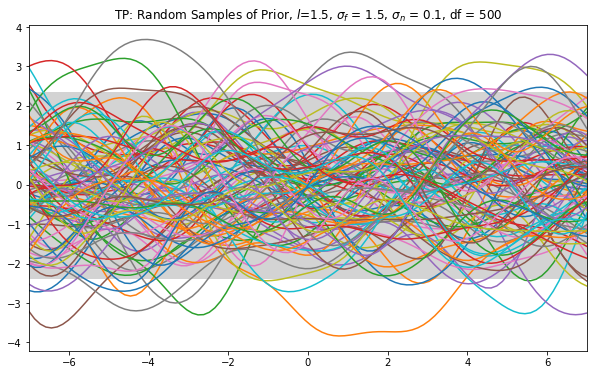

In [72]:
model_TP3 = TProcess(nu=500,sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.2)
model_TP3.plot_prior_samples(-7,7,100)

# Bayesian Learning and Posterior Experiments

Here we want to investigate what was mentioned several times before, namely how the Students t processes take the observed data into account in their uncertainty quantification. In order to do so it is useful to recall that the posterior variance of the TP is calculated according to 
\begin{align}
\text{cov}(\mathbf{y})=\frac{\nu + \beta -2}{\nu + n - 2}\times \tilde K_{22}
\end{align}
where $\tilde K_{22}$ is the posterior covariance of the Gaussian process. The TP variance is thus equivalent to the scaled Gaussian covariance, with scaling factor $\frac{\nu + \beta -2}{\nu + n - 2}$. Since $\beta$ can be bigger or smaller than $n$, depending on the variance of the data, the scaling behaviour of $\text{cov}(\mathbf{y})$ adjusts accordingly:
* if $\beta < n$, the scaling factor and hence also the the variance decreases for $\nu$  decreasing
* if $\beta > n$, the scaling factor and hence also the the variance increases for $\nu$  decreasing

For both cases, for $\nu\to\infty$ the prefactor becomes 1 and the Gaussian covariance is recovered. 

Nevertheless the variance is not enough to recover the confidence intervals of the GP since also the quantiles of the Student's distribution depend on $\nu$. For fixed $\nu$, however, the impact of the scale of the observed data can be seen nicely from the following experiment: We construct training data by drawing random $X$-values for which we construct the SE-Kernel, which we in return use for creating target data $y_{train}$ by drawing from a multivariate Normal. In other words, we create training data according to a GP. We then perform GP and TP regression on this data as well as on another data-set where the y-values were rescaled with a factor of 5. We choose a particular small value for $\nu$ (2.1) in order to be able to observe the effect of the changing scaling behaviour.
In the first two plots can see that both GP and TP fit the data very well when they are correctly specified. It is to note that the confidence interval of TP is smaller than the GP one (since here $\beta < n$). When the data is scaled up, however, the GP confidence intervals do not change (since they are independent of the data). The TP confidence intervals instead do increase strongly (note the scale of the plots), which is due to the change in $\beta$.

In [73]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

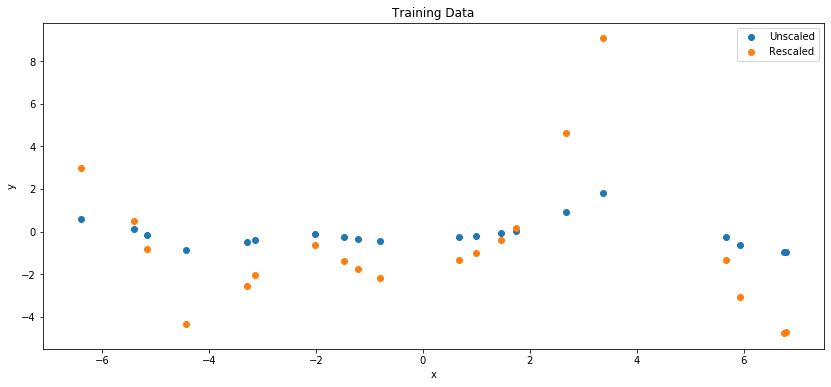

In [59]:
# generate GP data - scaled and unscaled
num_train=20
X_train=np.array([random.uniform(-7,7) for i in range(num_train)])
mu_train=np.zeros(num_train)
model_GP_train = GProcess(sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.3)
K_train=model_GP_train.fit_sigma(X_train)
y_train=np.random.multivariate_normal(mu_train,K_train,size=1)[0]
y_train_rescaled = 5*y_train

plt.figure(figsize=(14,6))
plt.title('Training Data')
plt.scatter(X_train,y_train, label = 'Unscaled')
plt.scatter(X_train,y_train_rescaled,label='Rescaled')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

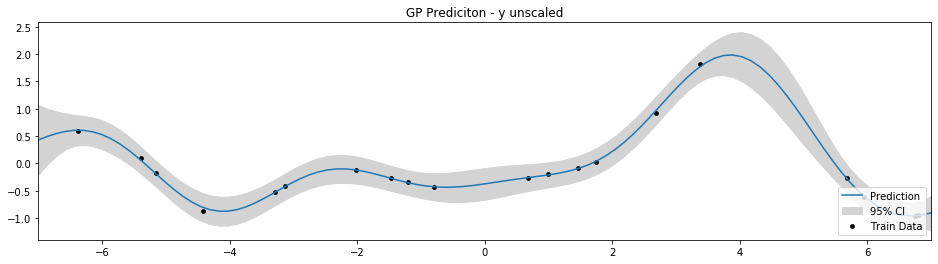

In [60]:
# Gaussian processes - unscaled data
model_GP=GProcess(sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.3)
model_GP.fit(X_train,y_train,optimize_SE=False)
model_GP.plot_range(-7,7)
plt.title('GP Prediciton - y unscaled')
plt.show()

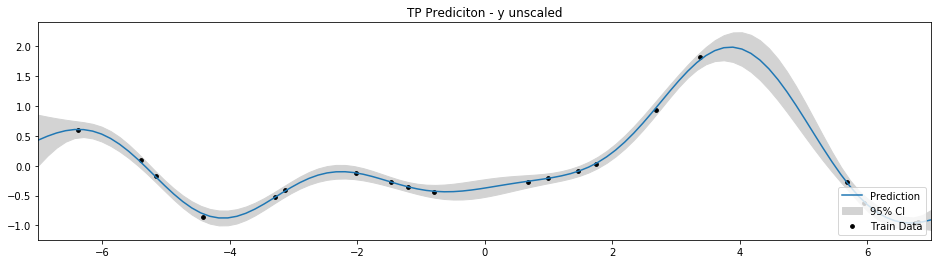

In [61]:
# Students T processes - unscaled data
model_TP=TProcess(nu=2.1,sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.3)
model_TP.fit(X_train,y_train,optimize_SE=False)
model_TP.plot_range(-7,7)
plt.title('TP Prediciton - y unscaled')
plt.show()

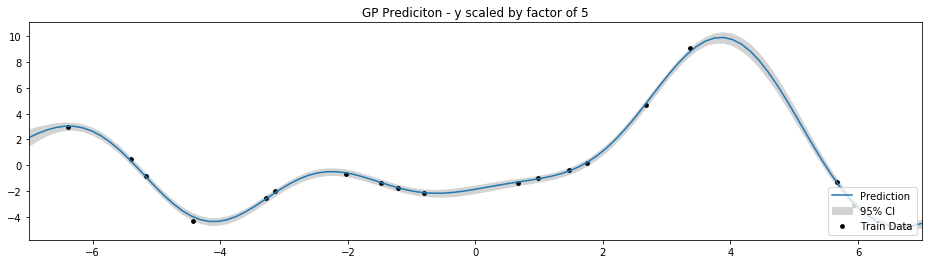

In [62]:
# Gaussian processes - scaled data
model_GP2=GProcess(sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.3)
model_GP2.fit(X_train,y_train_rescaled,optimize_SE=False)
model_GP2.plot_range(-7,7)
plt.title('GP Prediciton - y scaled by factor of 5')
plt.show()

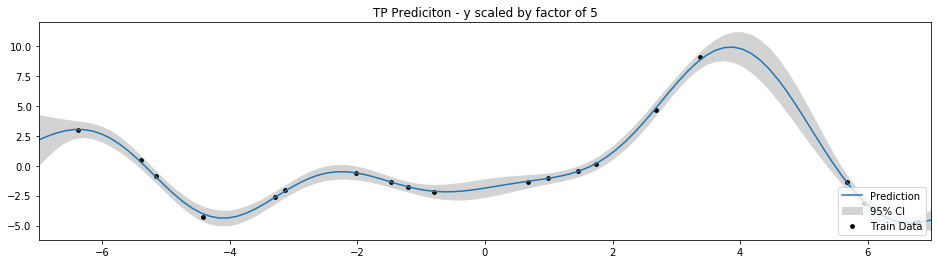

In [63]:
# Students T processes - scaled data
model_TP=TProcess(nu=2.1,sigma_n=0.1,kernel=kernel_f,sigma_f=1.5,l=1.3)
model_TP.fit(X_train,y_train_rescaled,optimize_SE=False)
model_TP.plot_range(-7,7)
plt.title('TP Prediciton - y scaled by factor of 5')
plt.show()

# Optimizing Hyperparameters
As explained in the first section, in a realistic scenario the parameters of the kernel as well as $\nu$ are not known. In order to find a suitable set of hyperparameters we therefore implemented pytorch routines. Pytorch conveniently keeps track of the gradients of all parameters during the computation. This makes it easy to perform a gradient-descent on the log-likelihood. We reuse the training data that we generated for the last example and fit a TP model with dramatically misspecified parameters. The TP fit can be seen in the first plot. In the second plot we show the fit after performing the log-likelihood optimization with pytorch over $\nu, \sigma_f, l$. The good fit supports the pytorch optimization approach, at least for synthetic data.

Text(0.5, 1.0, 'Unoptimized TP Fit')

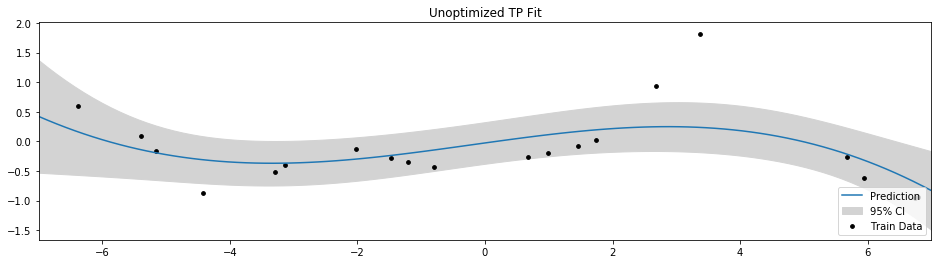

In [64]:
model_unopt=TProcess(nu=2.1,sigma_n=0.1,kernel=kernel_f,sigma_f=15.5,l=4.3)
model_unopt.fit(X_train,y_train,optimize_SE=False)
model_unopt.plot_range(-7,7)
plt.title('Unoptimized TP Fit')

Text(0.5, 1.0, 'Optimized TP Fit')

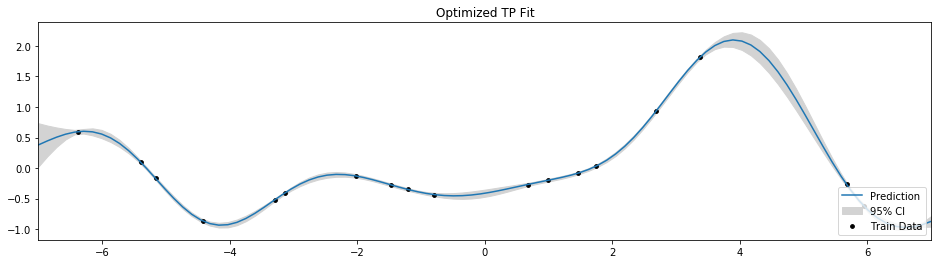

In [65]:
model_opt=TProcess(nu=2.1,sigma_n=0.1,kernel=kernel_f,sigma_f=15.5,l=4.3)
model_opt.fit(X_train,y_train,optimize_SE=True,threshold=0.00000000001)
model_opt.plot_range(-7,7)
plt.title('Optimized TP Fit')

# Real World Data

Next, we attempted to use our Student-t process class on real data. We decided to use the Amazon series from the 2nd homework and limit the analysis to the period September 2019-May 2020. As a quick experiment, we decided to use the returns over the previous two weeks as explanatory variables for the current return of the stock. For training data, we use a rolling window of a month.

Our hyperparameters optimization function struggled, as predictions with the optimized hyperparameters were not satisfying. This is probaly due to the fact that a simple gradient descent cannot handle the complexity of real data, and a more nuanced optimization strategy is required. Also, we did not optimize over the learning rate of the optimizer, which might bring further improvements, or try different kernels.

Thus, we manually set the hyperparameters and compared our model's predictions with observed returns in the plot below. It is important to notice that the period of interest, in particular the second half, is characterized by highly volatile and unpredictable stock market as a consequence of the Covid crisis.
Nevertheless, it can find the general trends of the data and seems to predict volatility quite well, although the magnitude of the returns is regularly underestimated. 

While these results are promising, without optimized hyperparameters it is hard to understand whether they are simply due to the choice of hyperparameters and if they could be improved with a broad hyperparameters optimization scheme. 

In [5]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [52]:
def lag_column(data, column, lags):
#Lag a column by specified number of lags
    data[f'{column}_l_{lags}'] = data[column].shift(-lags)
    return data

def lag_multi(data, column, lags, dropLast = True):
    for i in range(1,lags+1):
        data = lag_column(data, column, i)
    if dropLast is True:
        data.drop(data.tail(lags).index, inplace = True)
    return data

In [53]:
# read amazon series from problem set
# Compute returns and keep just date and returns
amazon = pd.read_csv('AMZN.csv')
amazon.sort_values('Date', axis=0, ascending=False, inplace=True)
amazon['return'] = np.log(amazon['Adj Close']) - np.log(amazon['Adj Close'].shift(-1))
#amazon['return'] = amazon['Adj Close']
amazon.dropna(inplace=True)
amazon = amazon[['Date','return']]
amazon.columns = ['date','return']
amazon.dropna(inplace=True)

In [54]:
# add lagged predictors
amazon_lagged = lag_multi(amazon.copy(), 'return', 10)
amazon_lagged.sort_values('date', axis=0, ascending=True, inplace=True)
# keep data from september 2019
amazon_lagged = amazon_lagged[387:]

In [55]:
y = amazon_lagged['return'].to_numpy()
X = amazon_lagged.iloc[:,2:].to_numpy()

In [56]:
tproc = TProcess(nu=10,sigma_n=0.05,kernel=None,l=4,sigma_f=.001)

In [57]:
v_preds = []
y_preds = []

for i in range(21,len(X)):
    y_train = y[i-21:i]
    X_train = X[i-21:i]
    tproc.fit(X_train,y_train, optimize_SE=False, threshold=.000000001, lr=.01)
    X_test = X[i]
    y_pred,v = tproc.predict(X_test)
    v_preds.append(v)
    y_preds.append(y_pred)

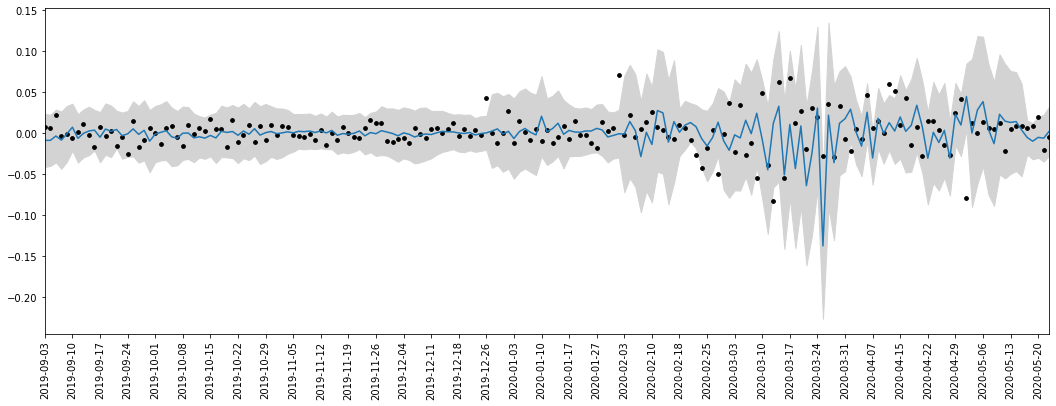

In [60]:
pref = stats.t(df=tproc.nu+30).ppf((0.025))
x = list(range(len(y_preds)))
x_sel = [a%5==0 for a in x]
x_labs = amazon_lagged.date[21:][x_sel]
x_ticks = [a for a in x if a%5==0]


plt.figure(figsize=(18,6))
plt.fill_between(x,y1=y_preds+pref*np.sqrt(v_preds),y2=y_preds-pref*np.sqrt(v_preds),color='lightgrey',label='95% CI')
plt.plot(x,y_preds,label='Prediction')
plt.scatter(x,y[21:],label='Train Data', color = 'black', s = 14)
plt.xlim(min(x),max(x))
plt.xticks(x_ticks,x_labs,rotation='vertical')

plt.show()

# Conclusions
In this project we were able to extend the concept of Gaussian Processes to Student's-t Processes. We implemented two fully working classes for each case. A particular feature of our implementation is its high flexibility: One can externally define kernels and pass them as arguments to the classes. Furthermore, we were able to implement a parameter optimization routine based on gradient descent for the SE kernel. This routine can easily be extended to general kernels in the future. We investigated the features of TP and compared them to GP. We in particular confirmed that the uncertainty in TP scales with the data variability in the $\mathbf{y}$, which was not the case for GP. Also, TP in general allows more extreme observations. The additional parameter $\nu$ makes TP more versatile since it permits more fine-tuning of the fitting process, in which for $\nu\to\infty$ GP is obtained. When applying TP regression to real-world data our optimization routine was somewhat struggling, but we could get a good fit by manually performing a grid-search over the hyperparameters. We believe that a more thorough parameter optimization which also invovles different kernels and an adaptive learning rate would yield better results here. Also, we fitted our data on the returns and it might be easier to predict the actual index.

Summing it up, we think that TP are a highly promising concept. We believe that with a more extensive setup involving more sophisticated hyperparameter tuning or optimization routines they can unfold their full potential and outpeform GP in many applications.

# References

+ Shah, Amar, Andrew Wilson, and Zoubin Ghahramani. "Student-t processes as alternatives to Gaussian processes." Artificial intelligence and statistics. 2014.
+ Solin, Arno, and Simo Särkkä. "State space methods for efficient inference in Student-t process regression." Artificial Intelligence and Statistics. 2015.
+ Tracey, Brendan D., and David Wolpert. "Upgrading from Gaussian processes to Student’st processes." 2018 AIAA Non-Deterministic Approaches Conference. 2018.
+ Lange, Kenneth. Numerical analysis for statisticians. Springer Science & Business Media, 2010.
+ Carl Edward Rasmussen and Christopher K. I. Williams. "Gaussian Processes for Machine Learning" The MIT Press, 2006. ISBN 0-262-18253-X.

